## ME6151 Assignment 2
#### By Anushka Venkatesh ME21B026

In [70]:
import sympy as smp
import numpy as np
import matplotlib.pyplot as plt

#### Function to create mesh and TDMA solver


In [60]:
# Functional Part of the Code

def discretize(y_side,z_side,delta_y,delta_z,initial_T=0):
    """ 
    Performs Spacial Discretization to create the mesh
    and assigns intial temperature value to all points
    Parameters:
    y_side= length along y direction
    z_side= length along z direction
    delta_y= cell size along y
    delta_z= cell size alond z
    initial_T= initial temperature guess
    """
    columns= int(z_side/delta_z)
    rows= int(y_side/delta_y)
    discretized_matrix= smp.Matrix(rows,columns,lambda i,j: initial_T)
    return discretized_matrix

def TDMA_solver(matrixA,matrixB):
    """
    TDMA solver for the 
    equation Ax=B
    """

    print("Initial matrixA:")
    print(matrixA)
    print("Initial matrixB:")
    print(matrixB)
     # Generate the Upper Triangular Matrix
    """Performing a modified form of gaussian elimination
    where the elimination is performed for only the row below
    the pivot, limiting the process to n steps"""
    
    
    for k in range(matrixA.rows-1):
        matrixA.row_op(k+1,lambda i,j: matrixA[k+1,j]-(matrixA[k,j]*matrixA[k+1,k]/matrixA[k,k]))
        matrixB.row_op(k+1,lambda i,j: matrixB[k+1,j]-(matrixB[k,j]*matrixA[k+1,k]/matrixA[k,k]))
    print("upper triangular=")
    print(matrixA)
    print("modified B:")
    print(matrixB)
    
    
    # Perform the backward substitution
    n = len(matrixB)
    x = np.zeros(n, dtype=float)  # Solution row matirx
    # Solve from last equation to the first
    for i in range(n-1, -1, -1):  
        x[i] = matrixB[i]
        for j in range(i+1, n):
            x[i] -= matrixA[i, j] * x[j]
        x[i] /= matrixA[i, i]  # Divide by diagonal element
    print("Temperature values:")
    print(x.reshape(-1, 1))
    return x.reshape(-1, 1)  # Return a column matrix (n x 1)
    
def ADI_solver(T_matrix,delta_y,delta_z,steps=5):
    """
    Performs the ADI method on the T_matrix and returns 
    temperature values after the specified number of iterations. 
    Parameters:
    T_Matrix= Initial Guess
    delta_y= cell size along y
    delta_z= cell size along z
    steps= no of iterations
    """
    
    #matirx to store iteration values of temperature
    rows,columns= T_matrix.shape
    T_inter= T_matrix
    
    # Performing Z and Y sweep alternatively
    
    for i in range(steps):
        for j in range(1,rows-1): #Z direction Sweep
            # this coefficient matrix is derived for problem 2
            [A_z,B_z]= coeff_matrix_z(T_inter[j+1,:],T_inter[j-1,:],delta_y,delta_z)
            print(TDMA_solver(A_z,B_z).T)
            T_inter[j,:]= TDMA_solver(A_z,B_z).T #Updated values after Z sweep
        
        for k in range(1,columns-1): #Y direction Sweep
            # this coefficient matrix is derived for problem 2
            [A_y,B_y]= coeff_matrix_y(T_inter[:,k+1],T_inter[:,k-1],delta_y,delta_z)
            print(TDMA_solver(A_y,B_y))
            T_inter[:,k]= TDMA_solver(A_y,B_y) #Updated values after Y sweep
            
        #Updating the 4 corner cells
        T_inter[0,0]=((T_inter[0,1]/delta_z**2) +(T_inter[1,0]/delta_y**2) -(2*C2/delta_y)-C1)/(2/delta_z**2) 
        T_inter[0,columns-1]=((T_inter[0,columns-2]/delta_z**2) +(T_inter[1,columns-1]/delta_y**2) -(2*C2/delta_y)-C1)/(2/delta_z**2) 
        T_inter[rows-1,0]=((T_inter[rows-1,1]/delta_z**2) +(T_inter[rows-2,0]/delta_y**2) -(2*C2/delta_y)-C1)/(2/delta_z**2) 
        T_inter[rows-1,columns-1]=((T_inter[rows-1,columns-2]/delta_z**2) +(T_inter[rows-2,columns-1]/delta_y**2) -(2*C2/delta_y)-C1)/(2/delta_z**2) 

    return T_inter

        
        
    

In [61]:
# Constants for problem 2
rho=1000 #kg/m^3
D= 1 #m
U=1 #m/s
Cp=4 #J/kg.K
k= 0.6 #W/m.K
q= 10 #j/m^2

# Create a 20x20 mesh
delta_y= 0.05 
delta_z= 0.05 

C1= 4*q/(rho*D*U*Cp*k)
C2= q/(rho*Cp*delta_z**2)

#### Functions to generate the coefficient matrices based on the physical condtions of problem 2

In [62]:
 
def coeff_matrix_z(up_row,down_row,delta_y,delta_z):
    """
    Generates the coefficient matrices A and B
    to obtain temperature values of each row
    Parameters:
    up_row : row above i.e north cells from previous iteration
    down_row: row below i.e south cells from previous iteration
    delta_y= cell size along y
    delta_z= cell size alond z
    """
    rows,columns= up_row.shape
    #print(rows)
    #print(columns)
    A=smp.Matrix(columns,columns,lambda i,j:0)
    #print(A.shape)
    B=smp.Matrix(columns,1,lambda i,j:0)
    
    for i in range(columns):
        if i!=0 and i!=columns-1 : # Discretized governing eq 
            A[i,i-1]= 1/delta_z**2
            A[i,i]= 2*((1/delta_z**2)+(1/delta_y**2))
            A[i,i+1]= -1/delta_z**2
            B[i]= (up_row[i]-down_row[i])/delta_y**2 -C1
            
        elif i==0: # Boundary Condition at z=0
            A[i,i]= 2*(1/delta_y**2)+(1/delta_z**2)
            A[i,i+1]= -1/delta_z**2
            B[i]= (up_row[i]-down_row[i])/delta_y**2 -C1 -(C2/delta_z)
            
        elif i==columns-1: # Boundary Condition at z=D
            A[i,i-1]= -1/delta_z**2
            A[i,i]= 2*(1/delta_y**2)+(1/delta_z**2)
            B[i]= (up_row[i]-down_row[i])/delta_y**2 -C1 -(C2/delta_z)
    
    return A,B

def coeff_matrix_y(right_colm, left_colm, delta_y, delta_z):
    """
    Generates the coefficient matrices A and 
    B to obtain temperature values of each column
    Parameters:
    right_colm: right column i.e east cells from previous iteration 
    left_colm: left column i.e west cells from previous iteration
    delta_y= cell size along y
    delta_z= cell size alond z
    """
    rows,columns= right_colm.shape
    #print(rows)
    #print(columns)
    A=smp.Matrix(rows,rows,lambda i,j:0)
    #print(A.shape)
    B=smp.Matrix(rows,1,lambda i,j:0)
    
    for i in range(rows):
        if i!=0 and i!=rows-1 : # Discretized governing eq 
            A[i,i-1]= 1/delta_y**2
            A[i,i]= 2*((1/delta_z**2)+(1/delta_y**2))
            A[i,i+1]= -1/delta_y**2
            B[i]= (right_colm[i]-left_colm[i])/delta_y**2 -C1
            
        elif i==0: # Boundary Condition at y=0
            A[i,i]= 2*(1/delta_z**2)+(1/delta_y**2)
            A[i,i+1]= -1/delta_y**2
            B[i]= (right_colm[i]-left_colm[i])/delta_y**2 -C1 -(C2/delta_y)
            
        elif i==rows-1: # Boundary Condition at y=D
            A[i,i-1]= -1/delta_y**2
            A[i,i]= 2*(1/delta_z**2)+(1/delta_y**2)
            B[i]= (right_colm[i]-left_colm[i])/delta_y**2 -C1 -(C2/delta_y)
    
    return A,B
 


In [63]:
# Running the Algorithm for T0=300K
T_mesh= discretize(D,D,delta_y,delta_z,initial_T=100)
T_final=ADI_solver(T_mesh,delta_y,delta_z,steps=2)

Initial matrixA:
Matrix([[1200.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [400.000000000000, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 400.000000000000, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 400.000000000000, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 400.000000000000, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 400.000000000000, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 400.000000000000, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 400.000000000000, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 400.000000000000, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0,

Temperature values:
[[33.32097497]
 [25.92591564]
 [25.92591564]
 [25.92591564]
 [25.92591564]
 [25.92591564]
 [25.92591564]
 [25.92591564]
 [25.92591565]
 [25.92591568]
 [25.92591575]
 [25.92591594]
 [25.92591642]
 [25.92591737]
 [25.92591813]
 [25.92591127]
 [25.92585023]
 [25.92548402]
 [25.9235309 ]
 [25.91356996]]
[[33.32097497 25.92591564 25.92591564 25.92591564 25.92591564 25.92591564
  25.92591564 25.92591564 25.92591565 25.92591568 25.92591575 25.92591594
  25.92591642 25.92591737 25.92591813 25.92591127 25.92585023 25.92548402
  25.9235309  25.91356996]]
Initial matrixA:
Matrix([[1200.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 5.68434188608080e-14, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, -1.42108547152020e-14, 5.68434188608080e-14, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0,

Temperature values:
[[31.1260272 ]
 [24.96569603]
 [24.96569603]
 [24.96569603]
 [24.96569603]
 [24.96569603]
 [24.96569602]
 [24.96569602]
 [24.96569602]
 [24.96569601]
 [24.96569598]
 [24.96569591]
 [24.96569567]
 [24.96569481]
 [24.96569119]
 [24.96567448]
 [24.96559342]
 [24.96519211]
 [24.96319092]
 [24.95319031]]
Initial matrixA:
Matrix([[1200.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [400.000000000000, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 400.000000000000, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 400.000000000000, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 400.000000000000, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 400.000000000000, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 400.0

Temperature values:
[[31.23554643]
 [24.99956621]
 [24.99956621]
 [24.99956621]
 [24.99956621]
 [24.99956621]
 [24.99956621]
 [24.99956621]
 [24.99956621]
 [24.9995662 ]
 [24.9995662 ]
 [24.99956617]
 [24.99956604]
 [24.99956539]
 [24.99956218]
 [24.99954617]
 [24.99946616]
 [24.99906614]
 [24.99706614]
 [24.98706614]]
[[31.23554643 24.99956621 24.99956621 24.99956621 24.99956621 24.99956621
  24.99956621 24.99956621 24.99956621 24.9995662  24.9995662  24.99956617
  24.99956604 24.99956539 24.99956218 24.99954617 24.99946616 24.99906614
  24.99706614 24.98706614]]
Initial matrixA:
Matrix([[1200.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 5.68434188608080e-14, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, -1.42108547152020e-14, 5.68434188608080e-14, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0,

Temperature values:
[[31.23757453]
 [25.00000526]
 [25.00000526]
 [25.00000526]
 [25.00000526]
 [25.00000526]
 [25.00000526]
 [25.00000526]
 [25.00000526]
 [25.00000526]
 [25.00000526]
 [25.00000523]
 [25.0000051 ]
 [25.00000446]
 [25.00000127]
 [24.99998527]
 [24.99990527]
 [24.99950527]
 [24.99750527]
 [24.98750527]]
Initial matrixA:
Matrix([[1200.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [400.000000000000, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 400.000000000000, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 400.000000000000, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 400.000000000000, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 400.000000000000, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 400.0

Temperature values:
[[31.23748832]
 [24.99998978]
 [24.99998978]
 [24.99998978]
 [24.99998978]
 [24.99998978]
 [24.99998978]
 [24.99998978]
 [24.99998978]
 [24.99998978]
 [24.99998977]
 [24.99998974]
 [24.99998962]
 [24.99998898]
 [24.99998578]
 [24.99996978]
 [24.99988978]
 [24.99948978]
 [24.99748978]
 [24.98748978]]
[[31.23748832 24.99998978 24.99998978 24.99998978 24.99998978 24.99998978
  24.99998978 24.99998978 24.99998978 24.99998978 24.99998977 24.99998974
  24.99998962 24.99998898 24.99998578 24.99996978 24.99988978 24.99948978
  24.99748978 24.98748978]]
Initial matrixA:
Matrix([[1200.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 5.68434188608080e-14, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, -1.42108547152020e-14, 5.68434188608080e-14, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0,

upper triangular=
Matrix([[1200.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 5.68434188608080e-14, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, -1.42108547152020e-14, 5.68434188608080e-14, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 3.55271367880050e-15, -1.42108547152020e-14, 5.68434188608080e-14, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, -8.88178419700125e-16, 3.55271367880050e-15, -1.42108547152020e-14, 5.68434188608080e-14, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 2.22044604925031e-16, -8.88178419700125e-16, 3.55271367880050e-15, -1.42108547152020e-14, 5.68434188608080e-14, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, -5.55111512312578e-17, 2.220

Temperature values:
[[25.32520458]
 [ 1.5518304 ]
 [ 7.80070838]
 [ 5.7178781 ]
 [ 6.41211171]
 [ 6.1807145 ]
 [ 6.25784112]
 [ 6.23213105]
 [ 6.24069303]
 [ 6.23781992]
 [ 6.23873176]
 [ 6.23833488]
 [ 6.23835511]
 [ 6.23866416]
 [ 6.24220576]
 [ 6.26381205]
 [ 6.37981731]
 [ 6.97403026]
 [ 9.96647028]
 [24.95319031]]
[[25.32520458]
 [ 1.5518304 ]
 [ 7.80070838]
 [ 5.7178781 ]
 [ 6.41211171]
 [ 6.1807145 ]
 [ 6.25784112]
 [ 6.23213105]
 [ 6.24069303]
 [ 6.23781992]
 [ 6.23873176]
 [ 6.23833488]
 [ 6.23835511]
 [ 6.23866416]
 [ 6.24220576]
 [ 6.26381205]
 [ 6.37981731]
 [ 6.97403026]
 [ 9.96647028]
 [24.95319031]]
Initial matrixA:
Matrix([[1200.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 5.68434188608080e-14, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, -1.42108547152020e-14, 5.68434188608080e-14, 1600.0

upper triangular=
Matrix([[1200.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, -1.42108547152020e-14, 0, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 3.55271367880050e-15, -1.42108547152020e-14, 0, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, -8.88178419700125e-16, 3.55271367880050e-15, -1.42108547152020e-14, 0, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 2.22044604925031e-16, -8.88178419700125e-16, 3.55271367880050e-15, -1.42108547152020e-14, 0, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, -5.55111512312578e-17, 2.22044604925031e-16, -8.88178419700125e-16, 3.55271367880050e-15, -1.42108547152020e-14, 0, 1600.00

upper triangular=
Matrix([[1200.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 5.68434188608080e-14, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, -1.42108547152020e-14, 5.68434188608080e-14, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 3.55271367880050e-15, -1.42108547152020e-14, 5.68434188608080e-14, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, -8.88178419700125e-16, 3.55271367880050e-15, -1.42108547152020e-14, 5.68434188608080e-14, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 2.22044604925031e-16, -8.88178419700125e-16, 3.55271367880050e-15, -1.42108547152020e-14, 5.68434188608080e-14, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, -5.55111512312578e-17, 2.220

upper triangular=
Matrix([[1200.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, -1.42108547152020e-14, 0, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 3.55271367880050e-15, -1.42108547152020e-14, 0, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, -8.88178419700125e-16, 3.55271367880050e-15, -1.42108547152020e-14, 0, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 2.22044604925031e-16, -8.88178419700125e-16, 3.55271367880050e-15, -1.42108547152020e-14, 0, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, -5.55111512312578e-17, 2.22044604925031e-16, -8.88178419700125e-16, 3.55271367880050e-15, -1.42108547152020e-14, 0, 1600.00

upper triangular=
Matrix([[1200.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 5.68434188608080e-14, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, -1.42108547152020e-14, 5.68434188608080e-14, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 3.55271367880050e-15, -1.42108547152020e-14, 5.68434188608080e-14, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, -8.88178419700125e-16, 3.55271367880050e-15, -1.42108547152020e-14, 5.68434188608080e-14, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 2.22044604925031e-16, -8.88178419700125e-16, 3.55271367880050e-15, -1.42108547152020e-14, 5.68434188608080e-14, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, -5.55111512312578e-17, 2.220

Temperature values:
[[ 7.8509766 ]
 [-0.00975145]
 [ 2.07813131]
 [ 1.38288893]
 [ 1.61447084]
 [ 1.53731313]
 [ 1.56302744]
 [ 1.55445784]
 [ 1.55732239]
 [ 1.5563839 ]
 [ 1.55674267]
 [ 1.55673877]
 [ 1.55703981]
 [ 1.55774985]
 [ 1.55995793]
 [ 1.56788763]
 [ 1.60121979]
 [ 1.7560603 ]
 [ 2.5107776 ]
 [ 6.25811482]]
Initial matrixA:
Matrix([[1200.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [400.000000000000, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 400.000000000000, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 400.000000000000, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 400.000000000000, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 400.000000000000, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 400.0

Temperature values:
[[7.79839594e+00]
 [7.17243839e-04]
 [2.08329045e+00]
 [1.38869637e+00]
 [1.62067339e+00]
 [1.54300095e+00]
 [1.56911245e+00]
 [1.56028669e+00]
 [1.56329089e+00]
 [1.56226314e+00]
 [1.56262388e+00]
 [1.56251588e+00]
 [1.56261844e+00]
 [1.56286192e+00]
 [1.56409267e+00]
 [1.57010413e+00]
 [1.60000859e+00]
 [1.74937968e+00]
 [2.49650505e+00]
 [6.23484342e+00]]
[[7.79839594e+00 7.17243839e-04 2.08329045e+00 1.38869637e+00
  1.62067339e+00 1.54300095e+00 1.56911245e+00 1.56028669e+00
  1.56329089e+00 1.56226314e+00 1.56262388e+00 1.56251588e+00
  1.56261844e+00 1.56286192e+00 1.56409267e+00 1.57010413e+00
  1.60000859e+00 1.74937968e+00 2.49650505e+00 6.23484342e+00]]
Initial matrixA:
Matrix([[1200.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 5.68434188608080e-14, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

upper triangular=
Matrix([[1200.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, -1.42108547152020e-14, 0, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 3.55271367880050e-15, -1.42108547152020e-14, 0, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, -8.88178419700125e-16, 3.55271367880050e-15, -1.42108547152020e-14, 0, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 2.22044604925031e-16, -8.88178419700125e-16, 3.55271367880050e-15, -1.42108547152020e-14, 0, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, -5.55111512312578e-17, 2.22044604925031e-16, -8.88178419700125e-16, 3.55271367880050e-15, -1.42108547152020e-14, 0, 1600.00

Temperature values:
[[7.95372238]
 [0.50774722]
 [3.71503558]
 [2.34988762]
 [2.8748253 ]
 [2.68334767]
 [2.75106829]
 [2.72757532]
 [2.73562331]
 [2.73288927]
 [2.7338124 ]
 [2.73350211]
 [2.73361538]
 [2.73365654]
 [2.73417868]
 [2.73727535]
 [2.75508696]
 [2.85385052]
 [3.38856262]
 [6.23436303]]
Initial matrixA:
Matrix([[1200.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [400.000000000000, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 400.000000000000, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 400.000000000000, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 400.000000000000, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 400.000000000000, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 400.000000000000, 1600.00

upper triangular=
Matrix([[1200.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 5.68434188608080e-14, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, -1.42108547152020e-14, 5.68434188608080e-14, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 3.55271367880050e-15, -1.42108547152020e-14, 5.68434188608080e-14, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, -8.88178419700125e-16, 3.55271367880050e-15, -1.42108547152020e-14, 5.68434188608080e-14, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 2.22044604925031e-16, -8.88178419700125e-16, 3.55271367880050e-15, -1.42108547152020e-14, 5.68434188608080e-14, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, -5.55111512312578e-17, 2.220

Temperature values:
[[ 6.01379149]
 [-0.99222289]
 [ 0.82746632]
 [ 0.26355539]
 [ 0.4371973 ]
 [ 0.38411959]
 [ 0.40019965]
 [ 0.39536942]
 [ 0.39677649]
 [ 0.3963139 ]
 [ 0.39632931]
 [ 0.39611235]
 [ 0.39595492]
 [ 0.39668274]
 [ 0.40282954]
 [ 0.43407056]
 [ 0.56753976]
 [ 1.07211821]
 [ 2.69522908]
 [ 6.17855633]]
[[ 6.01379149]
 [-0.99222289]
 [ 0.82746632]
 [ 0.26355539]
 [ 0.4371973 ]
 [ 0.38411959]
 [ 0.40019965]
 [ 0.39536942]
 [ 0.39677649]
 [ 0.3963139 ]
 [ 0.39632931]
 [ 0.39611235]
 [ 0.39595492]
 [ 0.39668274]
 [ 0.40282954]
 [ 0.43407056]
 [ 0.56753976]
 [ 1.07211821]
 [ 2.69522908]
 [ 6.17855633]]
Initial matrixA:
Matrix([[1200.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 5.68434188608080e-14, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, -1.42108547152020e-14, 5.68434188608080e-14, 1600.0

Temperature values:
[[ 6.08463103]
 [-1.00681193]
 [ 0.82363105]
 [ 0.2569679 ]
 [ 0.43133729]
 [ 0.37807469]
 [ 0.39419637]
 [ 0.3893779 ]
 [ 0.39080273]
 [ 0.39041053]
 [ 0.39056904]
 [ 0.39068574]
 [ 0.39123334]
 [ 0.39338469]
 [ 0.40220825]
 [ 0.43810359]
 [ 0.57899216]
 [ 1.09447445]
 [ 2.7328724 ]
 [ 6.2376992 ]]
Initial matrixA:
Matrix([[1200.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [400.000000000000, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 400.000000000000, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 400.000000000000, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 400.000000000000, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 400.000000000000, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 400.0

Temperature values:
[[ 6.08124664]
 [-1.00398671]
 [ 0.82114371]
 [ 0.26044787]
 [ 0.42984573]
 [ 0.37997385]
 [ 0.39407866]
 [ 0.39034279]
 [ 0.39122167]
 [ 0.39107391]
 [ 0.39109755]
 [ 0.39122328]
 [ 0.39167628]
 [ 0.39370748]
 [ 0.40231628]
 [ 0.43787726]
 [ 0.57822939]
 [ 1.09281573]
 [ 2.72980099]
 [ 6.23442409]]
[[ 6.08124664]
 [-1.00398671]
 [ 0.82114371]
 [ 0.26044787]
 [ 0.42984573]
 [ 0.37997385]
 [ 0.39407866]
 [ 0.39034279]
 [ 0.39122167]
 [ 0.39107391]
 [ 0.39109755]
 [ 0.39122328]
 [ 0.39167628]
 [ 0.39370748]
 [ 0.40231628]
 [ 0.43787726]
 [ 0.57822939]
 [ 1.09281573]
 [ 2.72980099]
 [ 6.23442409]]
Initial matrixA:
Matrix([[1200.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 5.68434188608080e-14, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, -1.42108547152020e-14, 5.68434188608080e-14, 1600.0

Temperature values:
[[ 6.13510754]
 [-0.82903925]
 [ 0.77884245]
 [ 0.37739254]
 [ 0.45832642]
 [ 0.45099123]
 [ 0.44638407]
 [ 0.45039711]
 [ 0.44820306]
 [ 0.44923279]
 [ 0.44881144]
 [ 0.44908528]
 [ 0.44943063]
 [ 0.45129758]
 [ 0.45920985]
 [ 0.49228718]
 [ 0.62421924]
 [ 1.11363556]
 [ 2.69639822]
 [ 6.2343591 ]]
Initial matrixA:
Matrix([[1200.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [400.000000000000, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 400.000000000000, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 400.000000000000, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 400.000000000000, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 400.000000000000, 1600.00000000000, -400.000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 400.0

In [64]:
T_final

Matrix([
[11.8172543369028,   9.70934243563835,  4.24633961749874,   6.93614252210203,   5.70195629624208,  6.24156554354227,   6.01379149145508,  6.10739417324223,  6.06973357909833,   6.0846310310734,  6.07882951073813,  6.08109848149022,  6.08037441606566,  6.08124664423879,   6.08345279248509,    6.0933567234628,   6.13510753679336,   6.31207995857956,  2.8146397820976, 4.79766848591517],
[14.0252079048339,  -5.42603307957699, 0.337376194434303,  -1.42580229270721, -0.872711494827483, -1.04948040226112, -0.992222894197007, -1.01094303667221, -1.00478176841071, -1.00681192946498, -1.00611379283776, -1.00623851130674, -1.00574341660604, -1.00398671054151, -0.996432375031045, -0.964468460756757, -0.829039246871017, -0.255242597219713, 2.17608624444093,  6.8807388563994],
[4.42381906237118, -0.532947085691888,   1.2861003369855,  0.675422549937316,  0.869139468597937, 0.810330139223593,   0.82746631974791, 0.822695289880536, 0.823941357789274, 0.823631054123346, 0.823642624069956, 0.82

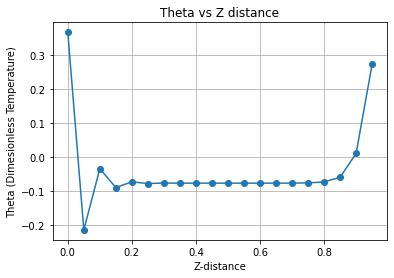

In [72]:
# Calculating the Bulk Temperature
N=D**2/(delta_y*delta_z) # number of cells
T_bulk= sum(T_final)/N
T_bulk

# Dimensionless Temperature along horizontal centre line
rows,columns= T_final.shape
i= int(rows/2)
theta=[]
for j in range(columns):
    theta.append((T_final[i,j]-T_bulk)/(q*D/k))
    
    
Z=[]
for j in range(columns):
    Z.append(j*delta_z)

# Plot Theta vs Z
plt.plot(Z, theta, marker='o', linestyle='-')
plt.xlabel("Z-distance")
plt.ylabel("Theta (Dimesionless Temperature)")
plt.title("Theta vs Z distance")
plt.grid(True)
plt.show()

In [77]:
# Calculating the Nusselt Number

# Avergare wall temperature
T_wall=0
for i in range(rows):
    T_wall+=T_final[i,0]+T_final[i,-1]
for j in range(columns):
    T_wall+=T_final[0,j]+T_final[-1,j]
    
n_z=int(D/delta_z)
n_y=int(D/delta_y)
    
T_wall= T_wall/(2*(n_z+n_y)-2)     

Nu= q*D/k/(T_wall-T_bulk)
Nu


3.27480956421886

### Problem 2 Part F
#### Exploring various intial guesses and mesh sizes

In [ ]:
# Case 1 - Mesh Size 20x20

delta_y=D/20
delta_z=D/20
rows=20
columns=20

In [ ]:
# Running the Algorithm for T0=100K


T_mesh_100_20= discretize(D,D,delta_y,delta_z,initial_T=1000)
T_final_100_20=ADI_solver(T_mesh_100_20,delta_y,delta_z,steps=6)

T_bulk=0
# Calculating the Bulk Temperature
N=D**2/(delta_y*delta_z) # number of cells
T_bulk= sum(T_final_100_20)/N
print(f'Bulk Temperature=',T_bulk)


# Calculating the Nusselt Number
# Avergare wall temperature
T_wall=0
for i in range(rows):
    T_wall+=T_final_100_20[i,0]+T_final_100_20[i,-1]
for j in range(columns):
    T_wall+=T_final_100_20[0,j]+T_final_100_20[-1,j]
    
n_z=int(D/delta_z)
n_y=int(D/delta_y)
    
T_wall= T_wall/(2*(n_z+n_y)-2)     

Nu= q*D/k/(T_wall-T_bulk)
print(f'Nusselt Number =',Nu)


# Plot the temperature distribution at cross section
T_final_np_100 = np.array(T_final_100_20).astype(float)

plt.figure(figsize=(8, 6))
plt.imshow(T_final_np_100, cmap='hot', origin='lower', extent=[0, D, 0, D], interpolation='bicubic')
plt.colorbar(label="Temperature (K)")
plt.xlabel("Z-distance (m)")
plt.ylabel("Y-distance (m)")
plt.title("2D Temperature Distribution")
plt.show()


In [ ]:
# T0=200K
T_mesh_200_20= discretize(D,D,delta_y,delta_z,initial_T=200)
T_final_200_20=ADI_solver(T_mesh_200_20,delta_y,delta_z,steps=2)

# Calculating the Bulk Temperature
T_bulk=0
N=D**2/(delta_y*delta_z) # number of cells
T_bulk= sum(T_final_200_20)/N
print(f'Bulk Temperature=',T_bulk)


# Calculating the Nusselt Number
# Avergare wall temperature
T_wall=0
for i in range(rows):
    T_wall+=T_final_200_20[i,0]+T_final_200_20[i,-1]
for j in range(columns):
    T_wall+=T_final_200_20[0,j]+T_final_200_20[-1,j]
    
n_z=int(D/delta_z)
n_y=int(D/delta_y)
    
T_wall= T_wall/(2*(n_z+n_y)-2)     

Nu= q*D/k/(T_wall-T_bulk)
print(f'Nusselt Number =',Nu)


# Plot the temperature distribution at cross section
T_final_np_200 = np.array(T_final_200_20).astype(float)

plt.figure(figsize=(8, 6))
plt.imshow(T_final_np_200, cmap='hot', origin='lower', extent=[0, D, 0, D], interpolation='bicubic')
plt.colorbar(label="Temperature (K)")
plt.xlabel("Z-distance (m)")
plt.ylabel("Y-distance (m)")
plt.title("2D Temperature Distribution")
plt.show()

In [ ]:
# T0=300K
T_mesh_300_20= discretize(D,D,delta_y,delta_z,initial_T=300)
T_final_300_20=ADI_solver(T_mesh_300_20,delta_y,delta_z,steps=2)

# Calculating the Bulk Temperature
T_bulk=0
N=D**2/(delta_y*delta_z) # number of cells
T_bulk= sum(T_final_300_20)/N
print(f'Bulk Temperature=',T_bulk)


# Calculating the Nusselt Number
# Avergare wall temperature
T_wall=0
for i in range(rows):
    T_wall+=T_final_300_20[i,0]+T_final_300_20[i,-1]
for j in range(columns):
    T_wall+=T_final_300_20[0,j]+T_final_300_20[-1,j]
    
n_z=int(D/delta_z)
n_y=int(D/delta_y)
    
T_wall= T_wall/(2*(n_z+n_y)-2)     

Nu= q*D/k/(T_wall-T_bulk)
print(f'Nusselt Number =',Nu)

# Plot the temperature distribution at cross section
T_final_np_300 = np.array(T_final_300_20).astype(float)

plt.figure(figsize=(8, 6))
plt.imshow(T_final_np_300, cmap='hot', origin='lower', extent=[0, D, 0, D], interpolation='bicubic')
plt.colorbar(label="Temperature (K)")
plt.xlabel("Z-distance (m)")
plt.ylabel("Y-distance (m)")
plt.title("2D Temperature Distribution")
plt.show()

In [ ]:
"""
    n = len(B)
    
    # Extract the diagonals
    a = np.zeros(n)  # Sub-diagonal (below main)
    b = np.zeros(n)  # Main diagonal
    c = np.zeros(n)  # Super-diagonal (above main)
    
    for i in range(n):
        b[i] = A[i, i]  # Main diagonal
        if i > 0:
            a[i] = A[i, i - 1]  # Sub-diagonal
        if i < n - 1:
            c[i] = A[i, i + 1]  # Super-diagonal

    d = np.array(B).astype(float).flatten()

    # Forward sweep
    for i in range(1, n):
        if abs(b[i - 1]) < 1e-12:  # Prevent division by zero
            raise ValueError(f"Zero pivot encountered at row {i - 1}")

        factor = a[i] / b[i - 1]
        b[i] -= factor * c[i - 1]
        d[i] -= factor * d[i - 1]

    # Backward substitution
    x = np.zeros(n)
    x[-1] = d[-1] / b[-1]

    for i in range(n - 2, -1, -1):
        x[i] = (d[i] - c[i] * x[i + 1]) / b[i]
    print("X matrix")    
    print(x.reshape(-1, 1))

    return x.reshape(-1, 1)  # Return as a column vecto
    
   
    N = len(matrixB)
    
    a = np.zeros(N)  #Sub-diagonal 
    b = np.zeros(N)  #Main diagonal
    c = np.zeros(N)  #Super-diagonal
    
    # Fill the diagonal vectors
    for i in range(N):
        b[i]= matrixA[i, i]  
        if i > 0:
            a[i]= matrixA[i, i- 1]  
        if i < N- 1:
            c[i]= matrixA[i, i+ 1]  
    d = np.array(matrixB).astype(float).flatten()
    
    cp = np.zeros(N,dtype='float64') # store tranformed c or c'
    dp = np.zeros(N,dtype='float64') # store transformed d or d'
    X = np.zeros(N,dtype='float64') # store unknown coefficients
    
    # Perform Forward Sweep
    # Equation 1 indexed as 0 in python
    cp[0] = c[0]/b[0]  
    dp[0] = d[0]/b[0]
    # Equation 2, ..., N (indexed 1 - N-1 in Python)
    for i in np.arange(1,(N),1):
        dnum = b[i] - a[i]*cp[i-1]
        cp[i] = c[i]/dnum
        dp[i] = (d[i]-a[i]*dp[i-1])/dnum
    
    # Perform Back Substitution
    X[(N-1)] = dp[N-1]  # Obtain last xn 

    for i in np.arange((N-2),-1,-1):  # use x[i+1] to obtain x[i]
        X[i] = (dp[i]) - (cp[i])*(X[i+1])
        
    print(X)    
    return(X)
    
    
    
   
    a = np.zeros(n)  #Sub-diagonal 
    b = np.zeros(n)  #Main diagonal
    c = np.zeros(n)  #Super-diagonal
    
    # Fill the diagonal vectors
    for i in range(n):
        b[i]= matrixA[i, i]  
        if i > 0:
            a[i]= matrixA[i, i- 1]  
        if i < n- 1:
            c[i]= matrixA[i, i+ 1]  
    d = np.array(matrixB).astype(float).flatten()
    
    # Forward substitution to compute Pi and Qi values
    P = np.zeros(n)
    Q = np.zeros(n)

    P[0]= -c[0]/b[0]
    Q[0]= d[0]/b[0]

    for i in range(1, n):
        denom= b[i]+ (a[i]* P[i- 1])
        print(denom)
        P[i]= -c[i]/ denom if i < n- 1 else 0  #Pi =0 for i=n-1 
        Q[i]= (d[i]- (a[i]* Q[i- 1])) / denom
        
    # Backward Substitution
    x = np.zeros(n)
    x[-1] = Q[-1]

    for i in range(n - 2, -1, -1):
        x[i] = P[i] * x[i + 1] + Q[i]
    print(x.reshape(-1, 1))

    return x.reshape(-1, 1)  # Return as a column vector
    
    for k in range(matrixA.rows-1):
        matrixA.row_op(k+1,lambda i,j: matrixA[k+1,j]-(matrixA[k,j]*matrixA[k+1,k]/matrixA[k,k]))
        matrixB.row_op(k+1,lambda i,j: matrixB[k+1,j]-(matrixB[k,j]*matrixA[k+1,k]/matrixA[k,k]))
    print("upper triangular=")
    print(matrixA)
    print("modified B:")
    print(matrixB)
    
    
    # Perform the backward substitution
    x = np.zeros(n, dtype=float)  # Solution row matirx
    # Solve from last equation to the first
    for i in range(n-1, -1, -1):  
        x[i] = matrixB[i]
        for j in range(i+1, n):
            x[i] -= matrixA[i, j] * x[j]
        x[i] /= matrixA[i, i]  # Divide by diagonal element
    print("Temperature values:")
    print(x.reshape(-1, 1))
    return x.reshape(-1, 1)  # Return a column matrix (n x 1)
    """
